This notebook:
- pulls Coinbase exchange data from 2015 - Q2 2018. 
- aggregates trading volume to USD 
- calculates summary statistics of aggregated trade volume

Assumptions used in analysis:
- data collected by hour; mid-point of hour, ((open + close) / 2), used as price for period
- USD volume of period = price as noted above * total coin volume for time period
- Assume one price/no arbitrage; i.e., assume BTC-EUR and BTC-USD trade at the same effective price for the same time period

See [Coinbase's documentation](https://developers.coinbase.com/api/v2) for more details.

In [1]:
# Import necessary packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
from operator import itemgetter
import requests
import csv

# Viewing options
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,10)  # default plot size
pd.options.display.max_columns = 500
pd.options.display.max_rows = 2000
pd.options.display.float_format = '{:,.3f}'.format # 2 decimals

In [2]:
# Set globals
PATH = os.getcwd()
api_url = 'https://api.pro.coinbase.com'
START = '2015-01-01 00:00:00'
END   = '2018-06-30 23:59:59'
STARTTIME = datetime.datetime.strptime(START, '%Y-%m-%d %H:%M:%S')
ENDTIME   = datetime.datetime.strptime(END, '%Y-%m-%d %H:%M:%S')

In [3]:
# Define Coinbase products
api_products = requests.get(api_url + '/products/', timeout=10)

In [4]:
# List Coinbase products, except ETC, which started trading in 08-2018
products = []
for item in api_products.json():
    if item['id'] not in ['ETC-EUR', 'ETC-USD', 'ETC-BTC']:
        products.append(item['id'])
products

['BTC-USD',
 'BCH-BTC',
 'BCH-USD',
 'BTC-EUR',
 'BTC-GBP',
 'ETH-BTC',
 'ETH-EUR',
 'ETH-USD',
 'LTC-BTC',
 'LTC-EUR',
 'LTC-USD',
 'BCH-EUR']

In [5]:
"""
Pull Coinbase data. 
Note: logging code left in even though it's not returned.

Args:
    starttime: begining of data series (first available data may start later)
    endtime: end of data series
    granularity: resolution of data in seconds; 3600 is 1 hour
    interval_seconds: size of range per API call; must be < (300 * granularity)
    product: exchange pair of data to pull
"""
def pull_coinbase_data(starttime, endtime, granularity, interval_seconds, product):
    interval_start = starttime
    interval_end   = starttime + datetime.timedelta(seconds=interval_seconds)

    data_bucket = []
    errors = 0
    errors_codes = []
    errors_json = []
    errors_intervals = []
    consecutive_errors = 0
    consecutive_errors_log = []

    while interval_start <= endtime:
        # uncomment below to print interval
        # print("[{}, {}]".format(interval_start.isoformat(), interval_end.isoformat()))

        params = {}
        params['start'] = interval_start
        params['end'] = interval_end
        params['granularity'] = granularity

        r = requests.get(api_url + '/products/{}/candles'.format(product), params=params, timeout=60)

        # If request results in error code, log error
        if r.status_code != 200:
            errors += 1
            errors_codes.append([r.status_code])
            errors_intervals.append([interval_start, interval_end])
            print('Error: {}'.format(r.status_code))
            consecutive_errors += 1

            # Sleep for 0.5 second to avoid hitting API rate limit
            time.sleep(0.5)

        # Otherwise append data to output and iterate interval window
        else:
            if consecutive_errors > 0:
                consecutive_errors_log.append(consecutive_errors)
                consecutive_errors = 0

            for i in sorted(r.json(), key=itemgetter(0)):
                data_bucket.append(i)

            # Set interval_start to 1 second past old interval_end
            interval_start = interval_end + datetime.timedelta(seconds=granularity)

            # Set interval_end to interval_start + INTERVAL_SECONDS or end_datetime
            interval_end = interval_start + datetime.timedelta(seconds=interval_seconds)
            if interval_end > endtime:
                  interval_end = endtime

            # Sleep for 0.5 seconds to avoid hitting API rate limit
            time.sleep(0.5)
    
    column_names = ['dt', 'low', 'high', 'open', 'close', 'vol']
    df_output = pd.DataFrame(data_bucket, columns=column_names)
    df_output['dt'] = pd.to_datetime(df_output['dt'], unit='s')
    df_output.set_index('dt', inplace=True)
    
    return df_output


In [6]:
# Takes a while to import all products' data, so save locally once done
starttime = STARTTIME
endtime = ENDTIME
granularity = 3600
interval_seconds = 900000

product_dfs = {}
for product in products:
    print('----------------------------------------')
    print('Product: {}'.format(product))
    df_import = pull_coinbase_data(starttime = starttime
        , endtime = endtime
        , granularity = granularity  # second duration of candlestick data
        , product = product
        , interval_seconds = interval_seconds)
    
    # Save
    df_import.to_csv(PATH+'/coinbase_data/'+product+'.csv')
    
    # Put in product_dfs
    product_dfs[product] = df_import
    
    del df_import
    print('{} Complete'.format(product))

----------------------------------------
Product: BTC-USD
BTC-USD Complete
----------------------------------------
Product: BCH-BTC
BCH-BTC Complete
----------------------------------------
Product: BCH-USD
BCH-USD Complete
----------------------------------------
Product: BTC-EUR
BTC-EUR Complete
----------------------------------------
Product: BTC-GBP
BTC-GBP Complete
----------------------------------------
Product: ETH-BTC
ETH-BTC Complete
----------------------------------------
Product: ETH-EUR
ETH-EUR Complete
----------------------------------------
Product: ETH-USD
ETH-USD Complete
----------------------------------------
Product: LTC-BTC
LTC-BTC Complete
----------------------------------------
Product: LTC-EUR
LTC-EUR Complete
----------------------------------------
Product: LTC-USD
LTC-USD Complete
----------------------------------------
Product: BCH-EUR
BCH-EUR Complete


In [7]:
# Aggregate by-hour trading value of coins
# Note: requires one price assumption (e.g., no arbitrage)

# Aggregate BTC trading volume
agg_btc = product_dfs['BTC-USD']['vol'].add(
    product_dfs['BTC-GBP']['vol'], fill_value=0).add(
    product_dfs['BTC-EUR']['vol'], fill_value=0)

# Aggregate ETH trading volume
agg_eth = product_dfs['ETH-USD']['vol'].add(
    product_dfs['ETH-EUR']['vol'], fill_value=0).add(
    product_dfs['ETH-BTC']['vol'], fill_value=0)

# Aggregate LTC trading volume
agg_ltc = product_dfs['LTC-USD']['vol'].add(
    product_dfs['LTC-EUR']['vol'], fill_value=0).add(
    product_dfs['LTC-BTC']['vol'], fill_value=0)

# Aggregate BCH trading volume
agg_bch = product_dfs['BCH-USD']['vol'].add(
    product_dfs['BCH-EUR']['vol'], fill_value=0).add(
    product_dfs['BCH-BTC']['vol'], fill_value=0)

In [8]:
# Calculate by-hour mid-price
# Note: Leads to one price assumption (e.g., no arbitrage)
usd_btc_price = (product_dfs['BTC-USD']['open'] + product_dfs['BTC-USD']['close']) / 2
usd_eth_price = (product_dfs['ETH-USD']['open'] + product_dfs['ETH-USD']['close']) / 2
usd_ltc_price = (product_dfs['LTC-USD']['open'] + product_dfs['LTC-USD']['close']) / 2
usd_bch_price = (product_dfs['BCH-USD']['open'] + product_dfs['BCH-USD']['close']) / 2

In [9]:
# Calculate USD value of coin's by-hour volme
usd_btc_vol = agg_btc * usd_btc_price
usd_eth_vol = agg_eth * usd_eth_price
usd_ltc_vol = agg_ltc * usd_ltc_price
usd_bch_vol = agg_bch * usd_bch_price

In [10]:
# Calculate total USD value of Coinbase volume
tot_usd_vol = usd_btc_vol.add(
                usd_eth_vol, fill_value=0).add(
                usd_ltc_vol, fill_value=0).add(
                usd_bch_vol, fill_value=0)

In [11]:
tot_usd_vol.head()

dt
2015-01-08 01:00:00   254.084
2015-01-08 02:00:00   442.460
2015-01-08 03:00:00   416.093
2015-01-08 04:00:00   378.225
2015-01-08 05:00:00   425.088
dtype: float64

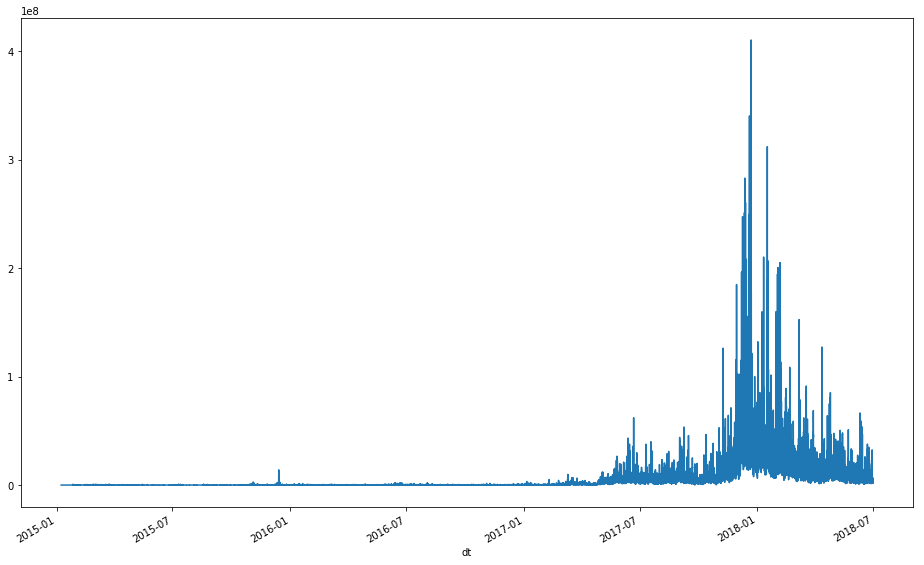

In [12]:
tot_usd_vol.plot()

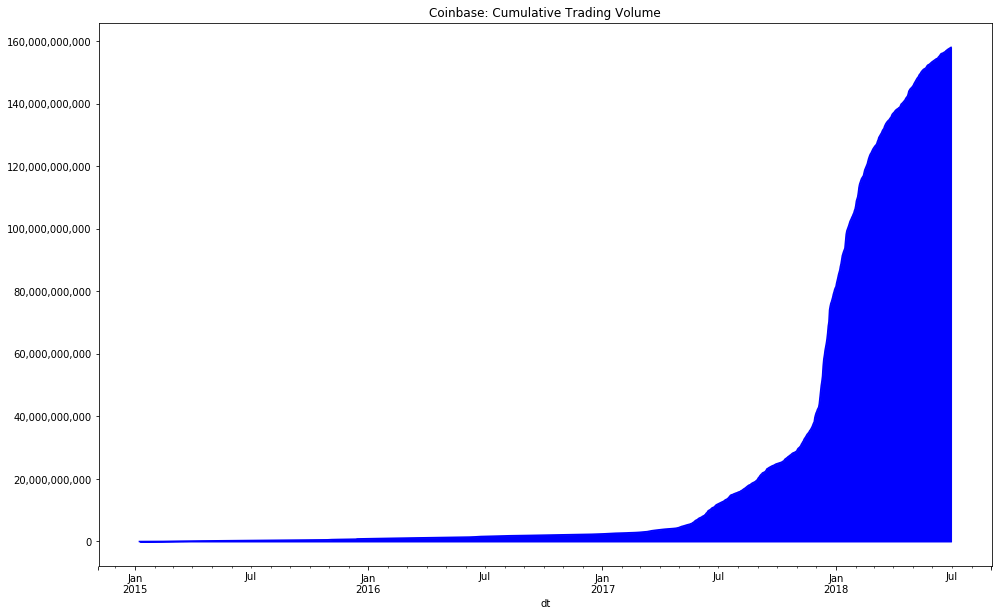

In [13]:
tot_usd_vol_d_cumsum = tot_usd_vol.resample('D').sum().cumsum()

ax = tot_usd_vol_d_cumsum.plot(title = "Coinbase: Cumulative Trading Volume" \
        , color='b')
ax.fill_between(tot_usd_vol_d_cumsum.index, tot_usd_vol_d_cumsum, where=tot_usd_vol_d_cumsum>=0, color='blue')

ax.get_yaxis().set_major_formatter(
    plt.matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.savefig('coinbase_cumulative_volume.png')
plt.show()

In [14]:
# Monthly totals
tot_usd_vol.resample('M').sum()

dt
2015-01-31        7,513,570.291
2015-02-28       63,590,843.409
2015-03-31       90,420,205.733
2015-04-30       54,794,567.834
2015-05-31       50,728,068.721
2015-06-30       47,705,558.227
2015-07-31       64,660,340.592
2015-08-31       58,645,539.895
2015-09-30       50,658,064.749
2015-10-31       74,375,522.881
2015-11-30      140,651,789.795
2015-12-31      203,656,891.336
2016-01-31      111,366,401.140
2016-02-29       89,392,200.606
2016-03-31       97,869,371.947
2016-04-30       84,028,061.571
2016-05-31      100,707,732.360
2016-06-30      242,585,794.074
2016-07-31      161,927,555.153
2016-08-31      127,955,208.736
2016-09-30       98,432,685.182
2016-10-31      109,698,458.917
2016-11-30      124,198,474.996
2016-12-31      180,614,673.030
2017-01-31      266,934,710.273
2017-02-28      246,632,817.854
2017-03-31      809,679,761.957
2017-04-30      677,611,393.141
2017-05-31    2,859,191,322.953
2017-06-30    4,659,551,602.643
2017-07-31    3,678,561,586.956
2017-

In [15]:
# Annual totals; note 2018 is only H1
tot_usd_vol.resample('Y').sum()

dt
2015-12-31      907,400,963.462
2016-12-31    1,528,776,617.712
2017-12-31   78,663,318,108.571
2018-12-31   76,924,190,630.353
Freq: A-DEC, dtype: float64